# Ptychography dose-overlap figure
> Georgios Varnavides*, Stephanie Ribet* et al.  
> 05/20/2024

This notebook reproduces the ptychography dose-overlap comparison figure (Fig. 9) in the manuscript [Iterative Phase Retrieval Algorithms for Scanning Transmission Electron Microscopy](https://arxiv.org/abs/2309.05250).

## Imports

In [1]:
import ase 
import abtem
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.ndimage import zoom,gaussian_filter

import cmasher as cmr
cmap = cmr.bubblegum

## abTEM Simulations

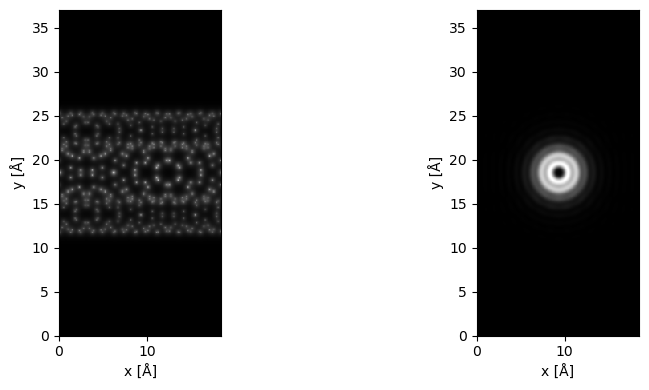

In [2]:
outer_cnt = ase.build.nanotube(12, 8, length=1)
inner_cnt = ase.build.nanotube(6, 4, length=1)
double_walled_cnt = outer_cnt + inner_cnt
double_walled_cnt.center(vacuum=0, axis=(0,1))
padding = double_walled_cnt.cell[2,2] - double_walled_cnt.cell[0,0]/2
double_walled_cnt.center(vacuum=padding, axis=(0,1))

# double_walled_cnt.rotate('x', 'z', rotate_cell=True)
# manual rotation
positions = double_walled_cnt.positions
positions_new = positions.copy()
positions_new[:,0] = positions[:,2]
positions_new[:,2] = positions[:,0]

double_walled_cnt = ase.Atoms(
    double_walled_cnt.symbols,
    positions = positions_new,
    cell=np.array([
        double_walled_cnt.cell[2,2],
        double_walled_cnt.cell[1,1],
        double_walled_cnt.cell[0,0]
    ])
)

double_walled_cnt_center = double_walled_cnt.cell.lengths()/2

frozen_phonons = abtem.temperature.FrozenPhonons(double_walled_cnt, 12, 0.075)

static_potential = abtem.Potential(
    #frozen_phonons,  # uncomment this for a realistic simulation     
    double_walled_cnt, # comment this for a realistic simulation
    gpts=(int(96*3*np.sqrt(2)/2),int(96*3*np.sqrt(2))),
    device="gpu",
    projection="infinite",
    parametrization="kirkland",
)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

static_potential.project().show(ax=ax1)
probe = abtem.Probe(semiangle_cutoff=25, energy=80e3, defocus=150,device="gpu")
probe.match_grid(static_potential)
probe.show(ax=ax2)

fig.tight_layout();

In [36]:
from functools import cache

@cache
def simulate_4Ddataset(gpts,pbar=False):
    pixelated_detector = abtem.PixelatedDetector(max_angle=None)
    
    grid_scan = abtem.GridScan(
        (0, static_potential.extent[1]/2-static_potential.extent[0]/2), (static_potential.extent[0],static_potential.extent[1]/2+static_potential.extent[0]/2),
        gpts=(gpts+1,gpts+1),
        endpoint=True
    )
    
    measurement = probe.scan(grid_scan, pixelated_detector, static_potential,pbar=pbar)
    return measurement

def return_noisy_array(gpts,electrons_per_area,pbar=False):
    measurement = simulate_4Ddataset(gpts,pbar=pbar)
    sx,sy,qx,qy = measurement.shape
    crop_qx = (qx - 96)//2
    crop_qy = (qy - 96*2)//2
    
    array = measurement.array[:,:,crop_qx:crop_qx+96,crop_qy:crop_qy+96*2]
    array = array.reshape((sx,sy,96,96,2)).sum(-1)
    
    electrons_per_probe = electrons_per_area*np.array(grid_scan.sampling).prod()
    noisy_array = np.random.poisson(array*electrons_per_probe).astype(np.uint16)
    return noisy_array, measurement.calibrations[0].sampling, measurement.calibrations[2].sampling

overlap_dose_dcs = []
for gpts in tqdm([6,9,12,18,36]):
    dose_dcs = []
    for dose in [1e6,1e5,1e4,1e3]:
        noisy_array, real_sampling, angular_sampling = return_noisy_array(gpts,dose,pbar=False)
        dc = py4DSTEM.DataCube(noisy_array)
        dc.calibration.set_R_pixel_size(real_sampling)
        dc.calibration.set_R_pixel_units('A')
        dc.calibration.set_Q_pixel_size(angular_sampling)
        dc.calibration.set_Q_pixel_units('mrad')
        dose_dcs.append(dc)

    overlap_dose_dcs.append(dose_dcs)

  0%|          | 0/5 [00:00<?, ?it/s]

## Single-Slice Reconstructions

In [37]:
overlap_dose_recons = []
overlap_dose_errors = []

for noise_index in tqdm(range(4)):
    
    dose_recons = []
    dose_errors = []
    for overlap_index in range(5):

        ptycho = py4DSTEM.process.phase.SingleslicePtychography(
            datacube=overlap_dose_dcs[overlap_index][noise_index],
            verbose=False,
            energy=80e3,
            semiangle_cutoff=25,
            defocus=150,
            device='gpu',
            storage='cpu',
            object_padding_px=(24,24),
        ).preprocess(
            force_com_rotation=0,
            force_com_transpose=False,
            plot_center_of_mass = False,
            plot_probe_overlaps=False,
        ).reconstruct(
            num_iter = 16,
            progress_bar=False,
            store_iterations=True,
            normalization_min=0.001,
        )

        dose_recons.append(np.angle(ptycho._crop_rotate_object_fov(ptycho.object)))
        dose_errors.append(ptycho.error)
        
    overlap_dose_recons.append(dose_recons)
    overlap_dose_errors.append(dose_errors)

  0%|          | 0/4 [00:00<?, ?it/s]

## Visualization

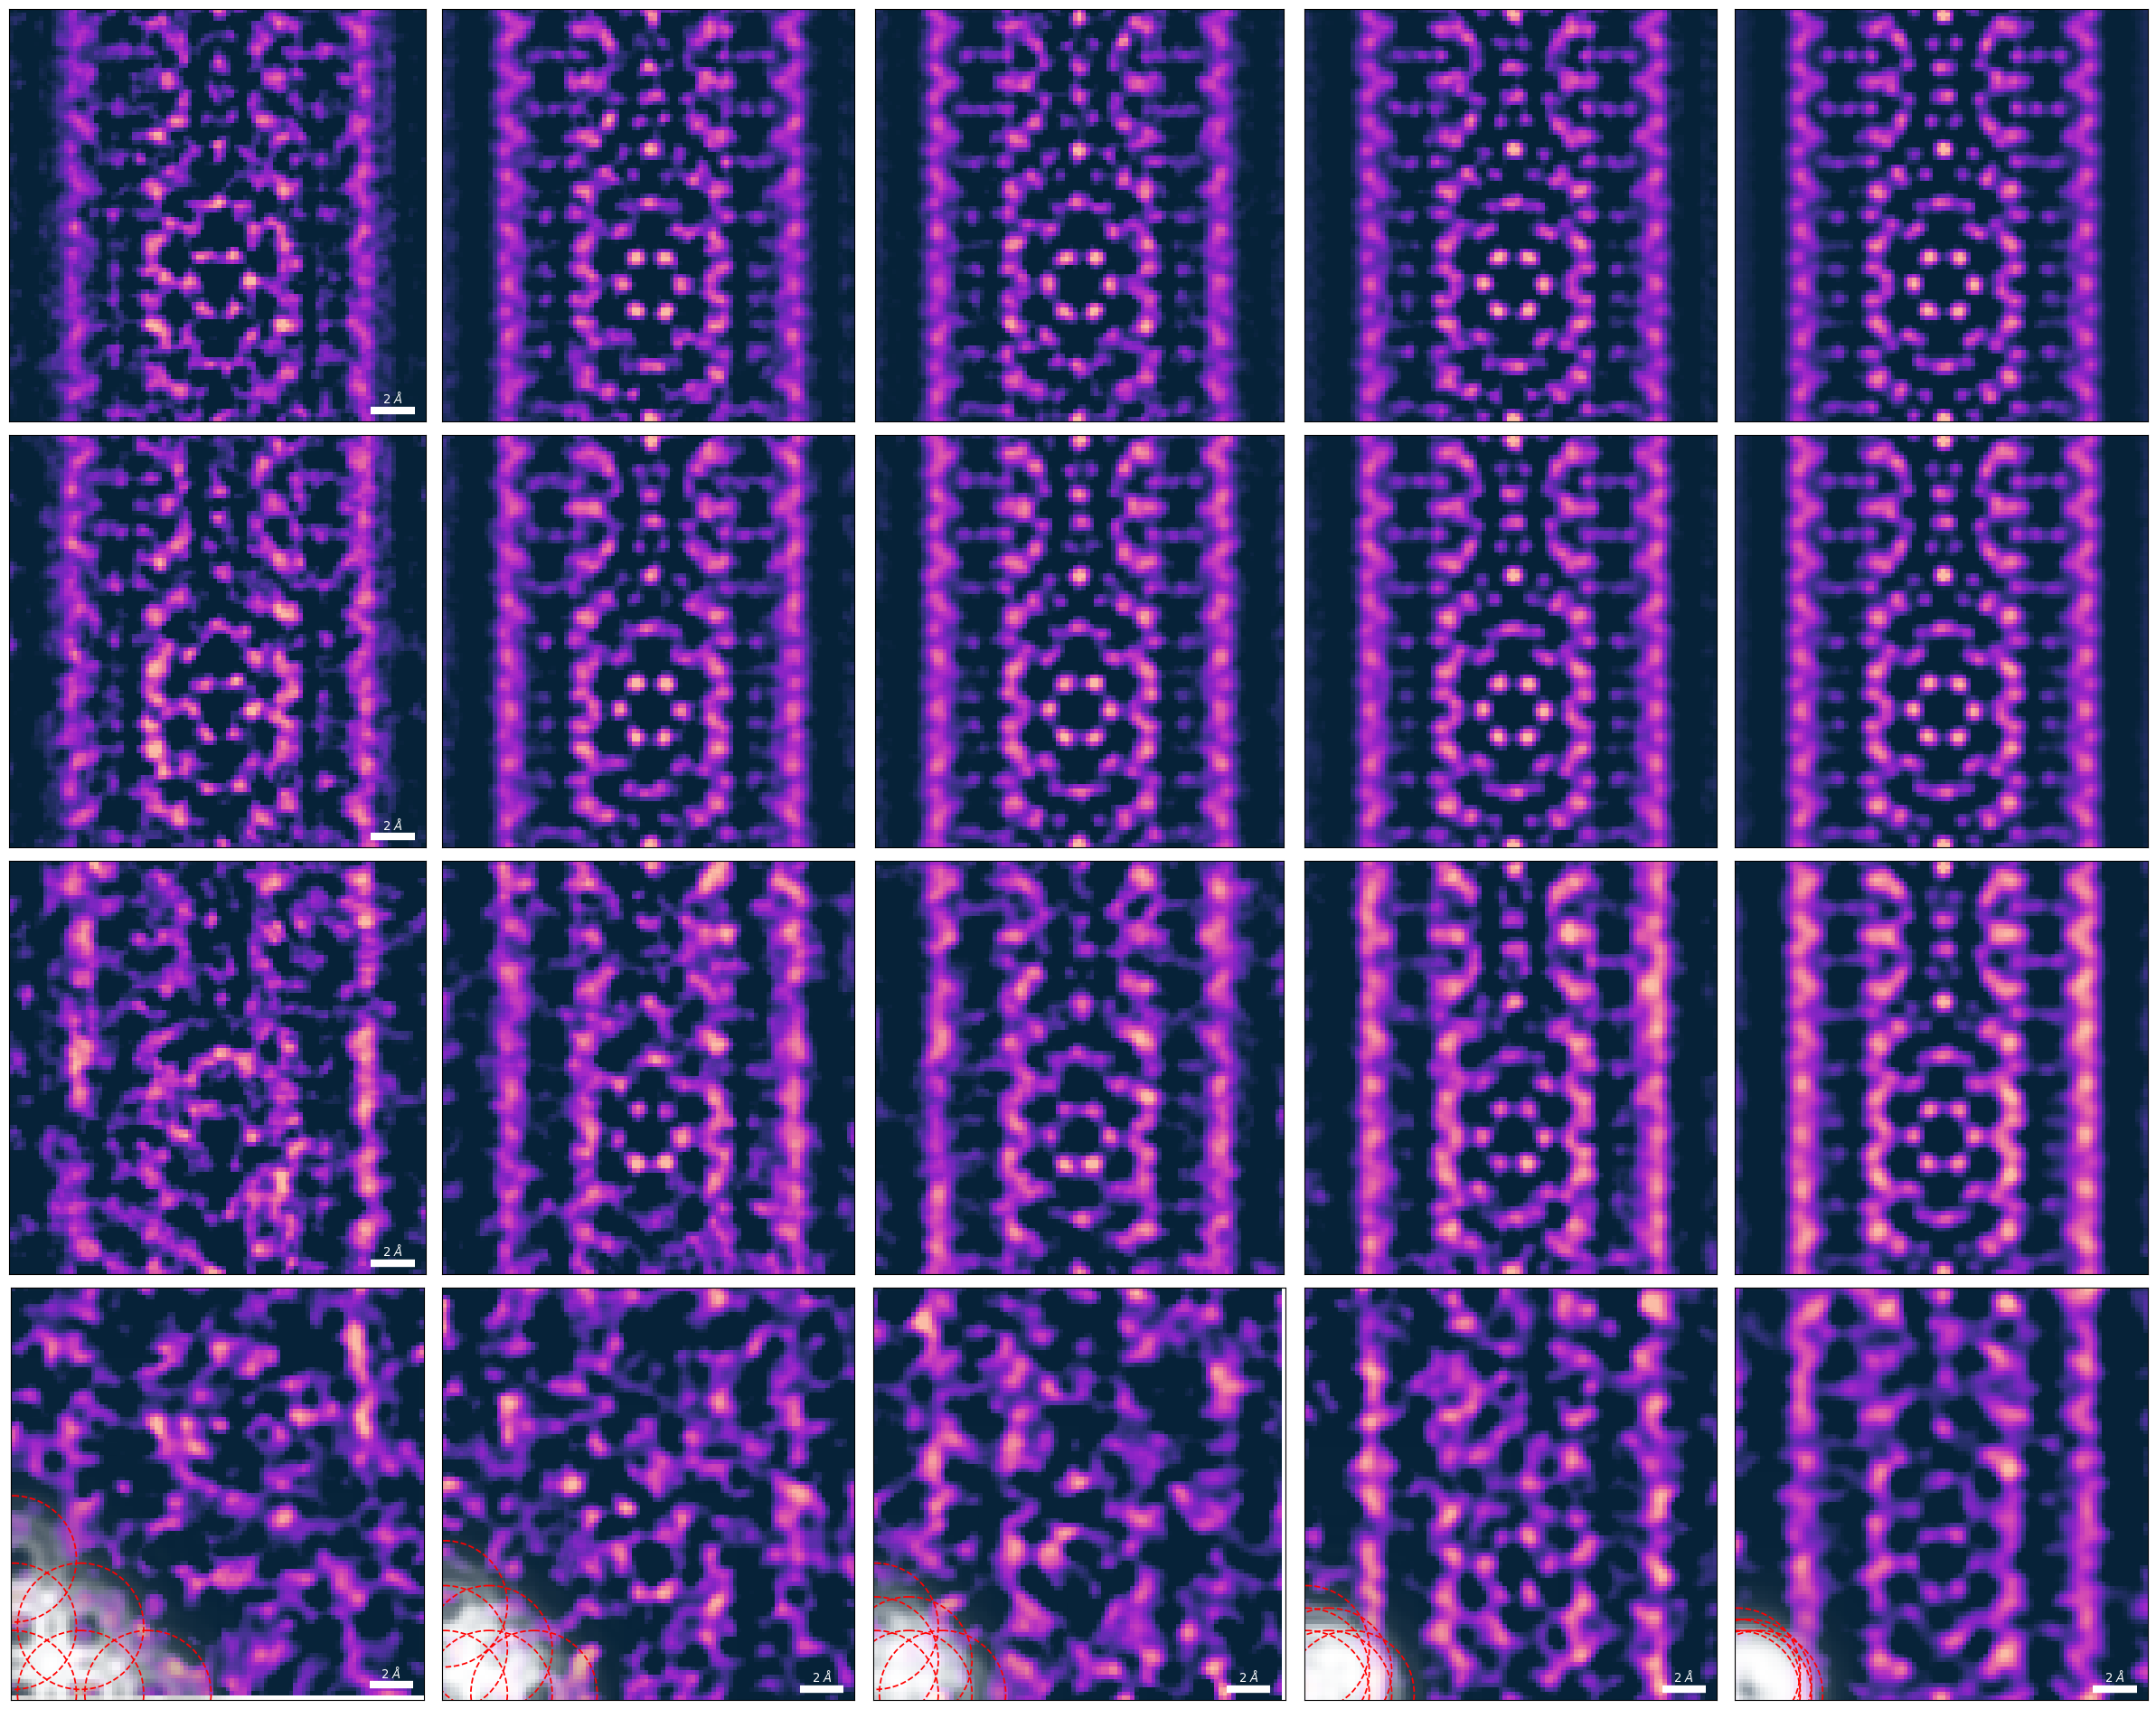

In [39]:
step_sizes = [overlap_dose_dcs[i][0].R_pixel_size/ptycho.sampling[0] for i in range(5)]
def prepare_overlap_inset_array(step_size):
    
    origin = ptycho._asnumpy(np.hstack((ptycho._positions_px[-1,0],ptycho._positions_px[0,1])))
    pos = np.vstack((
        origin,
        origin+(-step_size,0),
        origin+(-step_size*2,0),
        origin+(-step_size,step_size),
        origin+(0,step_size),
        origin+(0,step_size*2)
    ))
    fractional_pos = pos - np.round(pos)

    initialProbe = ptycho._asnumpy(ptycho._probe_initial)
    initialProbe /= np.sqrt(np.sum(np.abs(initialProbe)**2))
    shifted_probes = py4DSTEM.process.phase.utils.fft_shift(initialProbe, fractional_pos, np)
    probeIntensities = np.abs(shifted_probes)**2

    x0 = np.round(pos[:, 0]).astype("int")
    y0 = np.round(pos[:, 1]).astype("int")
    roi_shape = ptycho._region_of_interest_shape
    x_ind = np.fft.fftfreq(roi_shape[0], d=1 / roi_shape[0]).astype("int")
    y_ind = np.fft.fftfreq(roi_shape[1], d=1 / roi_shape[1]).astype("int")

    flat_weights = probeIntensities.ravel()
    indices = (
        (y0[:, None, None] + y_ind[None, None, :]) % ptycho._object_shape[1]
    ) + (
        (x0[:, None, None] + x_ind[None, :, None]) % ptycho._object_shape[0]
    ) * ptycho._object_shape[1]

    counts = np.bincount(
        indices.ravel(), weights=flat_weights, minlength=np.prod(ptycho._object_shape)
    )
    summed = ptycho._crop_rotate_object_fov(
        np.reshape(counts, ptycho._object_shape)
    )
    
    return pos, summed

def overlay_ax(recon, step_size, figax, scalebar=True, overlay=True):
    fig, ax = figax
    
    if overlay:
        pos, summed = prepare_overlap_inset_array(step_size)

        py4DSTEM.show(
            recon,
            vmin=0.333,
            vmax=0.999,
            cmap=cmap,
            figax=(fig,ax),
            ticks=False,
            scalebar=scalebar, 
            pixelsize=ptycho.sampling[0], 
            pixelunits='$\AA$',
            alpha=1-(summed/summed.max()).clip(0)
        )

        py4DSTEM.show(
            summed,
            figax=(fig,ax),
            ticks=False,
            vmin=0.0,
            vmax=0.00375,
            circle={'center':list(map(tuple, pos-ptycho._positions_px[0])),'R':15,'linewidth':1.25,'linestyle':'--'},
            intensity_range='absolute',
            alpha=(summed/summed.max()).clip(0)
        )
    else:
        py4DSTEM.show(
            recon,
            vmin=0.333,
            vmax=0.999,
            cmap=cmap,
            figax=(fig,ax),
            ticks=False,
            scalebar=scalebar, 
            pixelsize=ptycho.sampling[0], 
            pixelunits='$\AA$'
        )

fig, axs = plt.subplots(4,5,figsize=(24,19))
for overlap_index in range(5):
    for dose_index in range(4):
        overlay_ax(
            overlap_dose_recons[dose_index][overlap_index],step_sizes[overlap_index],(fig,axs[dose_index,overlap_index]),
            scalebar=dose_index == 3 or overlap_index==0,
            overlay= dose_index == 3
        )
        
fig.tight_layout()

## Postprocessing
> Done in Inkscape